In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import random
from transformers import BertTokenizer, BertModel
import json
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
torch.manual_seed(1)

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"

In [3]:
#check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

#### BiLSTM CRF model

In [5]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, target_size, embedding_mat, start_tag, end_tag, tag_to_ix, batch_size=1, device='cpu'):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.target_size = target_size
        self.batch_size = batch_size
        self.device = device
        self.tag_to_ix = tag_to_ix
        self.start_tag = start_tag
        self.end_tag = end_tag

        self.embedding = nn.Embedding.from_pretrained(embedding_mat).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True).to(device)
        self.hidden2tag = nn.Linear(hidden_dim, target_size).to(device)

        self.transitions_to = nn.Parameter(torch.randn(target_size, target_size)).to(device)
        self.transitions_to.data[start_tag, :] = -10000
        self.transitions_to.data[:, end_tag] = -10000

        # self.transitions_from = nn.Parameter(torch.randn(target_size, target_size))
        # self.transitions_from.data[:, start_tag] = -10000
        # self.transitions_from.data[end_tag, :] = -10000

        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(self.device),
                torch.randn(2, 1, self.hidden_dim // 2).to(self.device))

    def get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.embedding(sentence).view(len(sentence), 1, -1)
        #convert embeds to torch float32
        embeds = embeds.float()
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats


    def _forward_algo(self, lstm_features):

        scores = torch.full((1, self.target_size), -10000.).to(self.device)
        scores[0][self.start_tag] = 0.

        forward_var = scores

        for feat in lstm_features:
            next_tag_var = self.transitions_to + feat.view(-1, 1).expand(-1, self.target_size) + forward_var.expand(self.target_size, -1)
            max_score = next_tag_var.max(dim=1).values.view(-1, 1)
            next_tag_var = next_tag_var - max_score
            forward_var = (max_score + torch.logsumexp(next_tag_var, dim=1).view(-1, 1)).view(1, -1)
            
        terminal_var = (forward_var + self.transitions_to[self.end_tag]).view(1, -1)
        alpha = terminal_var
        max_score = alpha.max()
        alpha = max_score + torch.logsumexp(alpha - max_score, dim=1)
        return alpha
    

    def _score_sentence(self, lstm_features, tags):
        score = torch.zeros(1).to(self.device)
        tags = torch.cat([torch.tensor([self.tag_to_ix['START_TAG']], dtype=torch.long).to(self.device), tags])
        for i, feat in enumerate(lstm_features):
            score += self.transitions_to[tags[i + 1], tags[i]] + feat[tags[i + 1]]
                
        score += self.transitions_to[self.tag_to_ix['END_TAG'], tags[-1]]
        return score
    
    def neg_log_likelihood(self, sentence, tags):
        lstm_feats = self.get_lstm_features(sentence)
        forward_score = self._forward_algo(lstm_feats)
        gold_score = self._score_sentence(lstm_feats, tags)
        return forward_score - gold_score
    

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.target_size), -10000.).to(self.device)
        init_vvars[0][self.start_tag] = 0

        forward_var = init_vvars
        for feat in feats:
            bptrs_t = [] 
            viterbivars_t = [] 

            next_tag_var = self.transitions_to + forward_var.expand(self.target_size, -1)
            best_tag_id = torch.argmax(next_tag_var, dim=1)
            bptrs_t = best_tag_id
            viterbivars_t = next_tag_var[range(len(best_tag_id)), best_tag_id].view(1, -1)
            
            forward_var = (viterbivars_t + feat).view(1, -1)
            backpointers.append(bptrs_t)

        
        terminal_var = forward_var + self.transitions_to[self.end_tag]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

       
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id.item())
        
        start = best_path.pop()
        best_path.reverse()
        return path_score, best_path
        
    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self.get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

        

In [6]:
train_data = json.load(open('../Dataset/BIO_Tagged/ATE_train.json'))
val_data = json.load(open('../Dataset/BIO_Tagged/ATE_val.json'))
test_data = json.load(open('../Dataset/BIO_Tagged/ATE_test.json'))

In [7]:
word_to_idx = {}

for case in train_data:
    for text in train_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in test_data:
    for text in test_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

for case in val_data:
    for text in val_data[case]['text'].split(' '):
        if text not in word_to_idx:
            word_to_idx[text] = len(word_to_idx)

In [8]:
tag_to_ix = {}

for case in train_data:
    for tag in train_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in test_data:
    for tag in test_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

for case in val_data:
    for tag in val_data[case]['labels']:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

tag_to_ix['START_TAG'] = len(tag_to_ix)
tag_to_ix['END_TAG'] = len(tag_to_ix)

#### Bert Embeddings

In [9]:
tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
bert_model = BertModel.from_pretrained('nlpaueb/legal-bert-base-uncased')

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\models--nlpaueb--legal-bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
embedding_mat = np.zeros((len(word_to_idx), 768))

for word, idx in tqdm(word_to_idx.items()):
    # if word in tokenizer.vocab:
    #     embedding_mat[idx] = bert_model(tokenizer.encode(word))[1].detach().numpy()
    # else:
    #     embedding_mat[idx] = np.random.rand(768)
    try:
        tokens = tokenizer.batch_encode_plus([word], return_tensors='pt', add_special_tokens=False)
    except:
        tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
        continue
    embeddings = None
    with torch.no_grad():
        # outputs = bert_model(**tokens)
        # embeddings = outputs.last_hidden_state
        try:
            outputs = bert_model(**tokens)
            embeddings = outputs.last_hidden_state
        except:
            tokens = tokenizer.batch_encode_plus(['unk'], return_tensors='pt', add_special_tokens=False)
            outputs = bert_model(**tokens)
            embeddings = outputs.last_hidden_state
    embeddings = embeddings.squeeze(0)
    word_embeddings = embeddings.mean(dim = 0)
    embedding_mat[idx] = word_embeddings.squeeze(0).numpy()

100%|██████████| 3495/3495 [02:18<00:00, 25.17it/s]


In [11]:
pickle.dump(embedding_mat, open('Word Embeddings/legal_bert_embedding_mat.pkl', 'wb'))

In [12]:
embedding_mat = pickle.load(open('Word Embeddings/legal_bert_embedding_mat.pkl', 'rb'))

In [13]:
model = BiLSTM_CRF(len(word_to_idx), 768, 256, len(tag_to_ix), torch.tensor(embedding_mat), tag_to_ix['START_TAG'], tag_to_ix['END_TAG'], tag_to_ix, device=device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

EPOCHS = 20
train_loss = []
val_loss = []
train_macro_f1 = []
val_macro_f1 = []

for epoch in tqdm(range(EPOCHS), desc='Epoch'):
    loss = 0
    f1 = 0
    for i, case in tqdm(enumerate(train_data), desc=f'Epoch {epoch + 1}/{EPOCHS}'):
        sentence = prepare_sequence(train_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(train_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        model.train(True)
        model.zero_grad()
        loss = model.neg_log_likelihood(sentence, tags)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        with torch.no_grad():
            preds = model(sentence)[1]
            tags = tags.cpu().numpy()
            f1 += f1_score(tags, preds, average='macro')
    
    train_loss.append(loss/len(train_data))
    train_macro_f1.append(f1/len(train_data))
    
    model.eval()
    with torch.no_grad():
        loss = 0
        f1 = 0
        for case in val_data:
            sentence = prepare_sequence(val_data[case]['text'].split(' '), word_to_idx)
            tags = prepare_sequence(val_data[case]['labels'], tag_to_ix)
            setence = sentence.to(device)
            tags = tags.to(device)
            loss = model.neg_log_likelihood(sentence, tags)
            loss += loss.item()
            preds = model(sentence)[1]
            f1 += f1_score(tags.cpu().numpy(), preds, average='macro')
        val_macro_f1.append(f1/len(val_data))
        val_loss.append(loss/len(val_data))

    print()
    print(f'Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}')
    print(f'Train macro f1: {train_macro_f1[-1]}, Val macro f1: {val_macro_f1[-1]}')
    print(f'Epoch {epoch + 1}/{EPOCHS} done')

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20: 906it [00:23, 39.14it/s]
Epoch:   5%|▌         | 1/20 [00:26<08:20, 26.37s/it]


Train loss: tensor([0.0371], grad_fn=<DivBackward0>), Val loss: tensor([0.0848])
Train macro f1: 0.3740634436470932, Val macro f1: 0.3593610651457458
Epoch 1/20 done


Epoch 2/20: 906it [00:21, 42.63it/s]
Epoch:  10%|█         | 2/20 [00:51<07:44, 25.79s/it]


Train loss: tensor([0.0386], grad_fn=<DivBackward0>), Val loss: tensor([0.0812])
Train macro f1: 0.4128392372928649, Val macro f1: 0.39232341896403194
Epoch 2/20 done


Epoch 3/20: 906it [00:26, 34.84it/s]
Epoch:  15%|█▌        | 3/20 [01:20<07:42, 27.21s/it]


Train loss: tensor([0.0393], grad_fn=<DivBackward0>), Val loss: tensor([0.0819])
Train macro f1: 0.4516206030055731, Val macro f1: 0.4129343022873149
Epoch 3/20 done


Epoch 4/20: 906it [00:25, 34.89it/s]
Epoch:  20%|██        | 4/20 [01:49<07:23, 27.71s/it]


Train loss: tensor([0.0348], grad_fn=<DivBackward0>), Val loss: tensor([0.0828])
Train macro f1: 0.47134158175447327, Val macro f1: 0.4281436516502308
Epoch 4/20 done


Epoch 5/20: 906it [00:22, 40.16it/s]
Epoch:  25%|██▌       | 5/20 [02:14<06:41, 26.76s/it]


Train loss: tensor([0.0386], grad_fn=<DivBackward0>), Val loss: tensor([0.0907])
Train macro f1: 0.4981928966841504, Val macro f1: 0.4292677664040791
Epoch 5/20 done


Epoch 6/20: 906it [00:22, 39.68it/s]
Epoch:  30%|███       | 6/20 [02:39<06:08, 26.35s/it]


Train loss: tensor([0.0240], grad_fn=<DivBackward0>), Val loss: tensor([0.0911])
Train macro f1: 0.5147407551679862, Val macro f1: 0.4450996067253344
Epoch 6/20 done


Epoch 7/20: 906it [00:24, 36.90it/s]
Epoch:  35%|███▌      | 7/20 [03:07<05:47, 26.75s/it]


Train loss: tensor([0.0275], grad_fn=<DivBackward0>), Val loss: tensor([0.0883])
Train macro f1: 0.5267110671538436, Val macro f1: 0.4511483481177611
Epoch 7/20 done


Epoch 8/20: 906it [00:29, 31.10it/s]
Epoch:  40%|████      | 8/20 [03:38<05:39, 28.29s/it]


Train loss: tensor([0.0231], grad_fn=<DivBackward0>), Val loss: tensor([0.0856])
Train macro f1: 0.5341645792632947, Val macro f1: 0.45830019478076733
Epoch 8/20 done


Epoch 9/20: 906it [00:24, 36.55it/s]
Epoch:  45%|████▌     | 9/20 [04:06<05:07, 27.96s/it]


Train loss: tensor([0.0199], grad_fn=<DivBackward0>), Val loss: tensor([0.0770])
Train macro f1: 0.5416978230249958, Val macro f1: 0.445145822090987
Epoch 9/20 done


Epoch 10/20: 906it [00:25, 35.07it/s]
Epoch:  50%|█████     | 10/20 [04:34<04:40, 28.08s/it]


Train loss: tensor([0.0183], grad_fn=<DivBackward0>), Val loss: tensor([0.0805])
Train macro f1: 0.5529421569040085, Val macro f1: 0.45683081365843947
Epoch 10/20 done


Epoch 11/20: 906it [00:24, 36.46it/s]
Epoch:  55%|█████▌    | 11/20 [05:02<04:11, 27.93s/it]


Train loss: tensor([0.0200], grad_fn=<DivBackward0>), Val loss: tensor([0.0785])
Train macro f1: 0.5576967485487069, Val macro f1: 0.4482419541245897
Epoch 11/20 done


Epoch 12/20: 906it [00:25, 35.32it/s]
Epoch:  60%|██████    | 12/20 [05:30<03:44, 28.12s/it]


Train loss: tensor([0.0251], grad_fn=<DivBackward0>), Val loss: tensor([0.0801])
Train macro f1: 0.5645904981126713, Val macro f1: 0.4517387999174774
Epoch 12/20 done


Epoch 13/20: 906it [00:23, 39.01it/s]
Epoch:  65%|██████▌   | 13/20 [05:56<03:11, 27.39s/it]


Train loss: tensor([0.0217], grad_fn=<DivBackward0>), Val loss: tensor([0.0824])
Train macro f1: 0.5775683735226663, Val macro f1: 0.4731920795999098
Epoch 13/20 done


Epoch 14/20: 906it [00:23, 37.92it/s]
Epoch:  70%|███████   | 14/20 [06:23<02:43, 27.28s/it]


Train loss: tensor([0.0211], grad_fn=<DivBackward0>), Val loss: tensor([0.0834])
Train macro f1: 0.580420985050387, Val macro f1: 0.4703902593951966
Epoch 14/20 done


Epoch 15/20: 906it [00:23, 39.10it/s]
Epoch:  75%|███████▌  | 15/20 [06:49<02:14, 26.83s/it]


Train loss: tensor([0.0185], grad_fn=<DivBackward0>), Val loss: tensor([0.0863])
Train macro f1: 0.5863704660641934, Val macro f1: 0.458133193817859
Epoch 15/20 done


Epoch 16/20: 906it [00:21, 42.64it/s]
Epoch:  80%|████████  | 16/20 [07:13<01:43, 25.96s/it]


Train loss: tensor([0.0159], grad_fn=<DivBackward0>), Val loss: tensor([0.0866])
Train macro f1: 0.5948366018031511, Val macro f1: 0.4641926755198159
Epoch 16/20 done


Epoch 17/20: 906it [00:23, 38.16it/s]
Epoch:  85%|████████▌ | 17/20 [07:39<01:18, 26.08s/it]


Train loss: tensor([0.0195], grad_fn=<DivBackward0>), Val loss: tensor([0.0816])
Train macro f1: 0.6038051718450965, Val macro f1: 0.45538171352781004
Epoch 17/20 done


Epoch 18/20: 906it [00:21, 41.99it/s]
Epoch:  90%|█████████ | 18/20 [08:03<00:50, 25.42s/it]


Train loss: tensor([0.0217], grad_fn=<DivBackward0>), Val loss: tensor([0.0848])
Train macro f1: 0.6067466784363275, Val macro f1: 0.4712294174553499
Epoch 18/20 done


Epoch 19/20: 906it [00:22, 39.45it/s]
Epoch:  95%|█████████▌| 19/20 [08:28<00:25, 25.41s/it]


Train loss: tensor([0.0210], grad_fn=<DivBackward0>), Val loss: tensor([0.0809])
Train macro f1: 0.6180266837393104, Val macro f1: 0.4711484105731493
Epoch 19/20 done


Epoch 20/20: 906it [00:21, 43.12it/s]
Epoch: 100%|██████████| 20/20 [08:51<00:00, 26.60s/it]


Train loss: tensor([0.0150], grad_fn=<DivBackward0>), Val loss: tensor([0.0763])
Train macro f1: 0.6164160970142016, Val macro f1: 0.4737029778449311
Epoch 20/20 done


In [14]:
torch.save(model, 'Models/20_epochs_legalbert.pt')

In [15]:
pickle.dump(train_loss, open('Losses/20_epochs_train_loss.pkl', 'wb'))
pickle.dump(val_loss, open('Losses/20_epochs_val_loss.pkl', 'wb'))
pickle.dump(train_macro_f1, open('Macro_F1/20_epochs_train_macro_f1.pkl', 'wb'))
pickle.dump(val_macro_f1, open('Macro_F1/20_epochs_val_macro_f1.pkl', 'wb'))

In [16]:
train_loss = pickle.load(open('Losses/20_epochs_train_loss.pkl', 'rb'))
val_loss = pickle.load(open('Losses/20_epochs_val_loss.pkl', 'rb'))
train_macro_f1 = pickle.load(open('Macro_F1/20_epochs_train_macro_f1.pkl', 'rb'))
val_macro_f1 = pickle.load(open('Macro_F1/20_epochs_val_macro_f1.pkl', 'rb'))

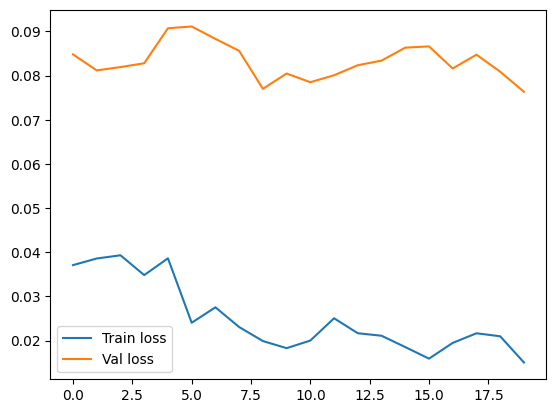

In [17]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.show()

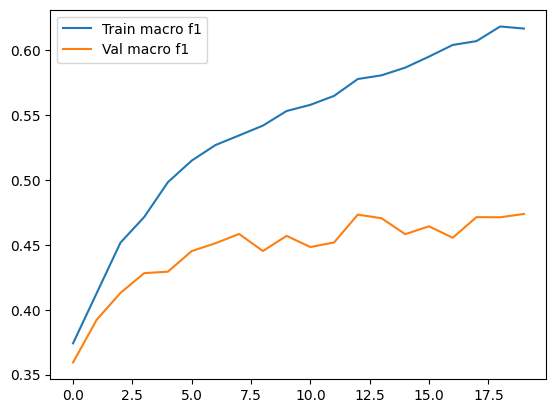

In [18]:
train_f1 = [i.item() for i in train_macro_f1]
val_f1 = [i.item() for i in val_macro_f1]

plt.plot(train_f1, label='Train macro f1')
plt.plot(val_f1, label='Val macro f1')
plt.legend()
plt.show()

In [19]:
model = torch.load('Models/20_epochs_legalbert.pt')

In [20]:
model.eval()
with torch.no_grad():
    f1 = 0
    for case in test_data:
        sentence = prepare_sequence(test_data[case]['text'].split(' '), word_to_idx)
        tags = prepare_sequence(test_data[case]['labels'], tag_to_ix)
        sentence = sentence.to(device)
        tags = tags.to(device)
        preds = model(sentence)[1]
        f1 += f1_score(tags.cpu().numpy(), preds, average='macro')
    print(f'Test macro f1: {f1/len(test_data)}')

Test macro f1: 0.4886508434848027
